In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
!gdown "1VIzvm1xahgBVybVPbHH2gRpTPKP-Rpzr&confirm=t"

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1VIzvm1xahgBVybVPbHH2gRpTPKP-Rpzr&confirm=t 



In [ ]:
dataset_path = "/content/drive/MyDrive/First aid dataset"
trn_path = os.path.join(dataset_path, "train")
val_path = os.path.join(dataset_path, "validation")

In [ ]:
trn_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1./255.,
  rotation_range=90,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='wrap'
)

trn_generator = trn_datagen.flow_from_directory(
  directory=trn_path,
  target_size=(224, 224),
  batch_size=32,
) 

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1./255.
)

val_generator = val_datagen.flow_from_directory(
  directory=val_path,
  target_size=(224, 224),
  batch_size=32,
) 

Found 342 images belonging to 7 classes.
Found 89 images belonging to 7 classes.


In [ ]:
acc = []
loss = []
val_acc = []
val_loss = []

In [ ]:
InceptionV3(
  weights="imagenet",
  include_top=False,
  input_shape=(224, 224, 3)
).summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_31[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [ ]:
def build_model():
  mobilenet = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
  )
  inception = InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
  )
  for layer in inception.layers[:-12]:
    layer.trainable = False
  x = inception.layers[-1].output
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(
    1024,
    activation="relu"
  )(x)
  x = tf.keras.layers.Dropout(
    0.6
  )(x)
  x = tf.keras.layers.Dense(
    512,
    activation="relu"
  )(x)
  x = tf.keras.layers.Dropout(
    0.3
  )(x)
  x = tf.keras.layers.Dense(
    256,
    activation="relu"
  )(x)
  x = tf.keras.layers.Dropout(
    0.2
  )(x)
  res = tf.keras.layers.Dense(
    7,
    activation="softmax"
  )(x)
  return tf.keras.Model(
    inputs=inception.input,
    outputs=res
  )

In [ ]:
build_model().summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 111, 111, 32  864         ['input_36[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_376 (Batch  (None, 111, 111, 32  96         ['conv2d_376[0][0]']             
 Normalization)                 )                                                           

In [ ]:
# learning_rate_sched_callback = tf.keras.optimizers.schedules.ExponentialDecay(
#   9.4043e-06,
#   decay_steps=20000,
#   decay_rate=0.9,
#   staircase=True
# )

early_stop_callback = tf.keras.callbacks.EarlyStopping(
  monitor="val_accuracy",
  patience=11,
  verbose=1
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath="/content/inceptionbb-checkpoints-2/{epoch:02d}.ckpt",
  save_weights_only=True,
  monitor="val_accuracy",
  mode="max",
  save_best_only=True,
  verbose=1
)

# reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor="val_accuracy",
#     mode="auto",
#     factor=0.8,
#     patience=2,
#     min_delta=0.001,
#     verbose=1
# )

In [ ]:
model = build_model()

In [ ]:
model.load_weights("/content/inceptionbb-checkpoints-2/70.ckpt")
model.compile(
  optimizer=tf.keras.optimizers.Adam(6.4e-05),
  loss="categorical_crossentropy",
  metrics=["accuracy"]
) 

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
with tf.device("GPU:0"):
  history = model.fit(
    trn_generator,
    epochs=180,
    verbose=1,
    validation_data=val_generator,
    callbacks=[checkpoint_callback, early_stop_callback]
  )

acc += history.history["accuracy"]
val_acc += history.history["val_accuracy"]
loss += history.history["loss"]
val_loss += history.history["val_loss"]

Epoch 1/180
11/11 [==============================] - ETA: 0s - loss: 0.9091 - accuracy: 0.6608
Epoch 1: val_accuracy did not improve from 0.70787
11/11 [==============================] - 17s 976ms/step - loss: 0.9091 - accuracy: 0.6608 - val_loss: 0.9253 - val_accuracy: 0.6517
Epoch 2/180
11/11 [==============================] - ETA: 0s - loss: 0.8464 - accuracy: 0.7018
Epoch 2: val_accuracy did not improve from 0.70787
11/11 [==============================] - 9s 782ms/step - loss: 0.8464 - accuracy: 0.7018 - val_loss: 0.9415 - val_accuracy: 0.6629
Epoch 3/180
11/11 [==============================] - ETA: 0s - loss: 0.8753 - accuracy: 0.6988
Epoch 3: val_accuracy did not improve from 0.70787
11/11 [==============================] - 8s 798ms/step - loss: 0.8753 - accuracy: 0.6988 - val_loss: 0.9389 - val_accuracy: 0.6629
Epoch 4/180
11/11 [==============================] - ETA: 0s - loss: 0.8427 - accuracy: 0.7193
Epoch 4: val_accuracy did not improve from 0.70787
11/11 [===============

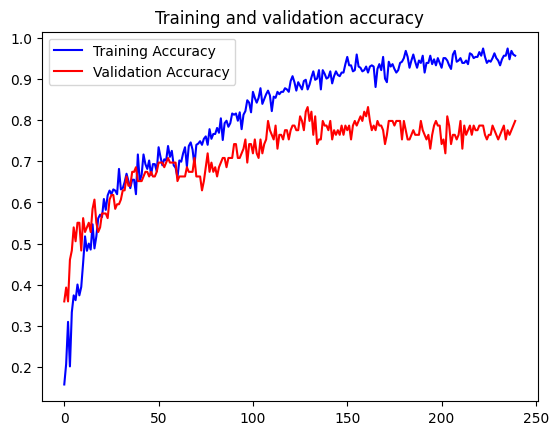

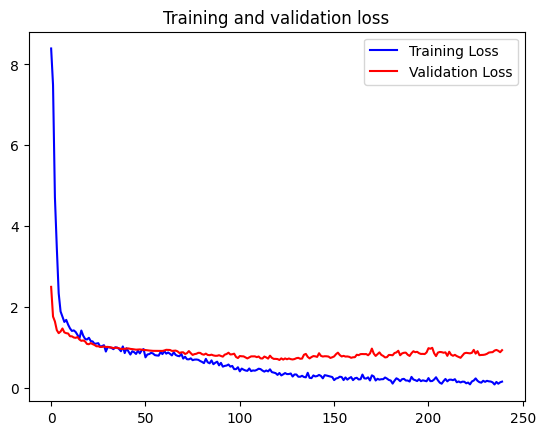

In [ ]:
import matplotlib.pyplot as plt

epochs = range(len(acc))

plt.plot(epochs, acc, "b", label="Training Accuracy")
plt.plot(epochs, val_acc, "r", label="Validation Accuracy")
plt.title("Training and validation accuracy")
plt.legend(loc=0)
plt.show()

plt.plot(epochs, loss, "b", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and validation loss")
plt.legend(loc=0)
plt.show()

In [ ]:
baseline_results = model.evaluate(
  val_generator,
  batch_size=32,
  verbose=1
)

3/3 [==============================] - 1s 217ms/step - loss: 0.7133 - accuracy: 0.8315


In [ ]:
model.load_weights("/content/inceptionbb-checkpoints-2/70.ckpt")
model.save("drive/MyDrive/myincmodel70.h5")


In [ ]:
!cp /content/inceptionbb-checkpoints-2/70.ckpt.data-00000-of-00001 /content/drive/MyDrive